In [4]:
import os
import sys
import glob
import random
import h5py
import staintools
import openslide
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import stardist
import seaborn as sns
from skimage.measure import regionprops_table
from stardist.models import StarDist2D
from stardist.plot import render_label
from csbdeep.utils import normalize
from scipy.stats import kruskal


def crop_im(img, new_width=448,new_height=448):
    width, height = img.size   # Get dimensions
    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2
    # Crop the center of the image
    img = img.crop((left, top, right, bottom))

In [ ]:
# sample patches from each Cluster
folder = '/scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/patches/HE'
WSIs = '/scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/WSIs'

df = pd.read_csv("/scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/RESULTs/SGK_UNI_BreastAgeNet_4clusters.csv")
patch_num = 10000
for cluster_id in [0,1,2,3]:
    patch_ids = list(df.loc[df['Cluster'] == cluster_id, "patch_id"])
    print(len(patch_ids))
    random.shuffle(patch_ids)
    
    for patch_id in patch_ids[:patch_num]:
        save_pt = f"{folder}/{patch_id}.tif"
        print(save_pt)
        wsi_id = parse_wsi_id(patch_id)
        try:
            wsi_path = glob.glob(f"{WSIs}/*/{wsi_id}*.*")[0]
            wsi = openslide.OpenSlide(wsi_path)
            x, y, patch_size = get_xy(patch_id)
            im = wsi.read_region((x, y), 0, (patch_size, patch_size)).convert("RGB")
        except Exception as e:
            print(f"Error processing WSI {wsi_id} for patch {patch_id}: {e}")
            continue  # Skip this patch if there's an issue
        
        patch_im_norm = Reinhard(np.array(im))
        patch_im_norm = Image.fromarray(patch_im_norm)
        patch_im_norm = crop_im(patch_im_norm)
        patch_im_norm.save(save_pt)

In [ ]:
# apply Stardist to segmente nuclei features of saved patches
PATCH = "/scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/patches/HE"
NUCLEI = "/scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/patches/startdist"
nuclei_csv = "/scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/RESULTs/SGK_Cluster_NucleiMorphology.csv"

for patch_id in os.listdir(PATCH): 
    tar_pt = f'{NUCLEI}/{patch_id.replace(".tif", "_nu.tif")}'
    if not os.path.exists(tar_pt):
        try:
            print(tar_pt)
            patch_norm = Image.open(f"{PATCH}/{patch_id}")
            patch_im_norm = np.array(patch_norm)
            # get nuclei spatial coordinates
            model = StarDist2D.from_pretrained('2D_versatile_he')
            labels, details = model.predict_instances(normalize(patch_im_norm))
            seg_im = Image.fromarray(labels.astype(bool))
            seg_im.save(tar_pt)
            print(f"{tar_pt} saved!")
            # plot_contours(patch_im, details["coord"])
            # get nuclei features
            nuclei_props_list = ["label", "area", "bbox_area", "extent", "eccentricity", "perimeter", 
                                 "major_axis_length", "minor_axis_length", "solidity"]
            props = regionprops_table(labels, properties=nuclei_props_list)
            props_df = pd.DataFrame.from_dict(props)
            props_df["Circularity"] = (4*np.pi*props_df["area"]) / (props_df["major_axis_length"]**2)
            props_df["Elongation"] = props_df["major_axis_length"] / props_df["minor_axis_length"]
            props_df["patch_id"] = patch_id
            props_df["coord_x"] = details["points"][:,0]
            props_df["coord_y"] = details["points"][:,1]
            
            if not os.path.exists(nuclei_csv):
                props_df.to_csv(nuclei_csv, index=False)
            else:
                props_df.to_csv(nuclei_csv, mode="a", header=False, index=False)
        except:
            pass

In [ ]:
# apply Stardist to segmente nuclei features of saved patches
PATCH = "/scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/patches/HE"
NUCLEI = "/scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/patches/startdist"
nuclei_csv = "/scratch_tmp/prj/cb_normalbreast/prj_BreastAgeNet/RESULTs/SGK_Cluster_NucleiMorphology.csv"

for patch_id in os.listdir(PATCH): 
    tar_pt = f'{NUCLEI}/{patch_id.replace(".tif", "_nu.tif")}'
    if not os.path.exists(tar_pt):
        try:
            print(tar_pt)
            patch_norm = Image.open(f"{PATCH}/{patch_id}")
            patch_im_norm = np.array(patch_norm)
            # get nuclei spatial coordinates
            model = StarDist2D.from_pretrained('2D_versatile_he')
            labels, details = model.predict_instances(normalize(patch_im_norm))
            seg_im = Image.fromarray(labels.astype(bool))
            seg_im.save(tar_pt)
            print(f"{tar_pt} saved!")
            # plot_contours(patch_im, details["coord"])
            # get nuclei features
            nuclei_props_list = ["label", "area", "bbox_area", "extent", "eccentricity", "perimeter", 
                                 "major_axis_length", "minor_axis_length", "solidity"]
            props = regionprops_table(labels, properties=nuclei_props_list)
            props_df = pd.DataFrame.from_dict(props)
            props_df["Circularity"] = (4*np.pi*props_df["area"]) / (props_df["major_axis_length"]**2)
            props_df["Elongation"] = props_df["major_axis_length"] / props_df["minor_axis_length"]
            props_df["patch_id"] = patch_id
            props_df["coord_x"] = details["points"][:,0]
            props_df["coord_y"] = details["points"][:,1]
            
            if not os.path.exists(nuclei_csv):
                props_df.to_csv(nuclei_csv, index=False)
            else:
                props_df.to_csv(nuclei_csv, mode="a", header=False, index=False)
        except:
            pass


In [11]:
nuclei_df = pd.read_csv(nuclei_csv)
nuclei_df['patch_id'] = [i.split('.tif')[0] for i in list(nuclei_df['patch_id'])]
nuclei_df = pd.merge(nuclei_df, df.loc[:, ['patch_id', 'Cluster']], on = 'patch_id')
nuclei_df

97843608.py (1): Columns (524) have mixed types. Specify dtype option on import or set low_memory=False.


,label,area,bbox_area,extent,eccentricity,perimeter,major_axis_length,minor_axis_length,solidity,Circularity,Elongation,patch_id,coord_x,coord_y,Cluster
0,1,193.0,256.0,0.753906,0.451388,49.455844,16.594833,14.808031,0.955446,8.806866,1.120664,K108959_48774_4217_5561_4543_196_29_254,260,310,1
1,2,146.0,182.0,0.802198,0.505477,42.384776,14.692902,12.677623,0.966887,8.498603,1.158964,K108959_48774_4217_5561_4543_196_29_254,108,334,1
2,3,103.0,130.0,0.792308,0.734347,36.142136,13.913546,9.444152,0.953704,6.686078,1.473245,K108959_48774_4217_5561_4543_196_29_254,292,266,1
3,4,116.0,154.0,0.753247,0.703764,38.970563,14.417547,10.242713,0.928000,7.012697,1.407591,K108959_48774_4217_5561_4543_196_29_254,150,190,1
4,5,145.0,195.0,0.743590,0.730952,43.798990,16.517790,11.272219,0.947712,6.678424,1.465354,K108959_48774_4217_5561_4543_196_29_254,206,212,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1931743,11,93.0,130.0,0.715385,0.726092,34.384776,13.182262,9.064088,0.948980,6.725320,1.454340,K107731_49364_11543_2549_2290_196_47_259,304,332,1
1931744,11,93.0,130.0,0.715385,0.726092,34.384776,13.182262,9.064088,0.948980,6.725320,1.454340,K107731_49364_11543_2549_2290_196_47_259,304,332,1
1931745,11,93.0,130.0,0.715385,0.726092,34.384776,13.182262,9.064088,0.948980,6.725320,1.454340,K107731_49364_11543_2549_2290_196_47_259,304,332,1
1931746,11,93.0,130.0,0.715385,0.726092,34.384776,13.182262,9.064088,0.948980,6.725320,1.454340,K107731_49364_11543_2549_2290_196_47_259,304,332,1


In [12]:
# aggregate nuclei features for each patch
agg_df = nuclei_df.groupby('patch_id').agg(
    area_mean=('area', 'mean'),
    bbox_area_mean=('bbox_area', 'mean'),
    extent_mean=('extent', 'mean'),
    eccentricity_mean=('eccentricity', 'mean'),
    perimeter_mean=('perimeter', 'mean'),
    major_axis_length_mean=('major_axis_length', 'mean'),
    minor_axis_length_mean=('minor_axis_length', 'mean'),
    solidity_mean=('solidity', 'mean'),
    circularity_mean=('Circularity', 'mean'),
    elongation_mean=('Elongation', 'mean'),
    nuclei_count=('patch_id', 'size'),  # Count number of nuclei per patch (size of the group)
    coord_x_mean=('coord_x', 'mean'),  # Optional: mean of coordinates if needed
    coord_y_mean=('coord_y', 'mean'),  # Optional: mean of coordinates if needed
    cluster_mode=('Cluster', lambda x: x.mode()[0])  # Mode of 'Cluster' to represent dominant cluster
).reset_index()

agg_df

,patch_id,area_mean,bbox_area_mean,extent_mean,eccentricity_mean,perimeter_mean,major_axis_length_mean,minor_axis_length_mean,solidity_mean,circularity_mean,elongation_mean,nuclei_count,coord_x_mean,coord_y_mean,cluster_mode
0,K105969_2972_9656_3044_2787_15_43_256,1926.000000,2708.800000,0.706233,0.772057,149.502352,52.190686,32.107092,0.915998,5.510506,1.865560,55,192.800000,267.600000,2
1,K105969_2972_9656_3044_2787_15_44_256,1915.400000,2578.000000,0.738072,0.639098,139.942554,47.754058,32.401593,0.934293,7.139259,1.402992,45,215.600000,290.000000,3
2,K105969_2972_9656_3044_2787_16_42_256,999.818182,1459.363636,0.697358,0.751534,96.364571,34.486588,21.056789,0.933886,6.116491,1.677656,88,220.909091,264.363636,2
3,K105969_2972_9656_3044_2787_16_43_256,1994.142857,2844.000000,0.721325,0.600732,151.473114,49.192441,34.640658,0.914795,7.461392,1.318308,49,250.000000,299.142857,3
4,K105969_2972_9656_3044_2787_16_45_256,1628.833333,2256.833333,0.746006,0.507165,124.475818,41.614155,28.572540,0.929036,7.954212,1.264657,42,245.000000,299.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39084,K109288_9552_6754_3011_2503_44_29_254,1062.454545,1398.818182,0.768378,0.523591,89.005733,31.567709,21.641334,0.954265,8.086367,1.257145,264,235.090909,237.454545,1
39085,K109288_9552_6754_3011_2503_44_31_254,2316.500000,3163.750000,0.759583,0.551285,164.021338,54.868278,37.591101,0.928554,7.606715,1.321943,100,189.500000,254.500000,2
39086,K109288_9552_6754_3011_2503_45_30_254,1437.300000,2032.000000,0.745986,0.638655,121.337172,39.640610,28.867345,0.929167,7.234843,1.348770,220,243.000000,292.000000,2
39087,K109288_9552_6754_3011_2503_45_31_254,1083.700000,1428.800000,0.754230,0.621899,90.839401,32.030381,21.774133,0.945980,7.417070,1.360242,230,240.400000,253.000000,1


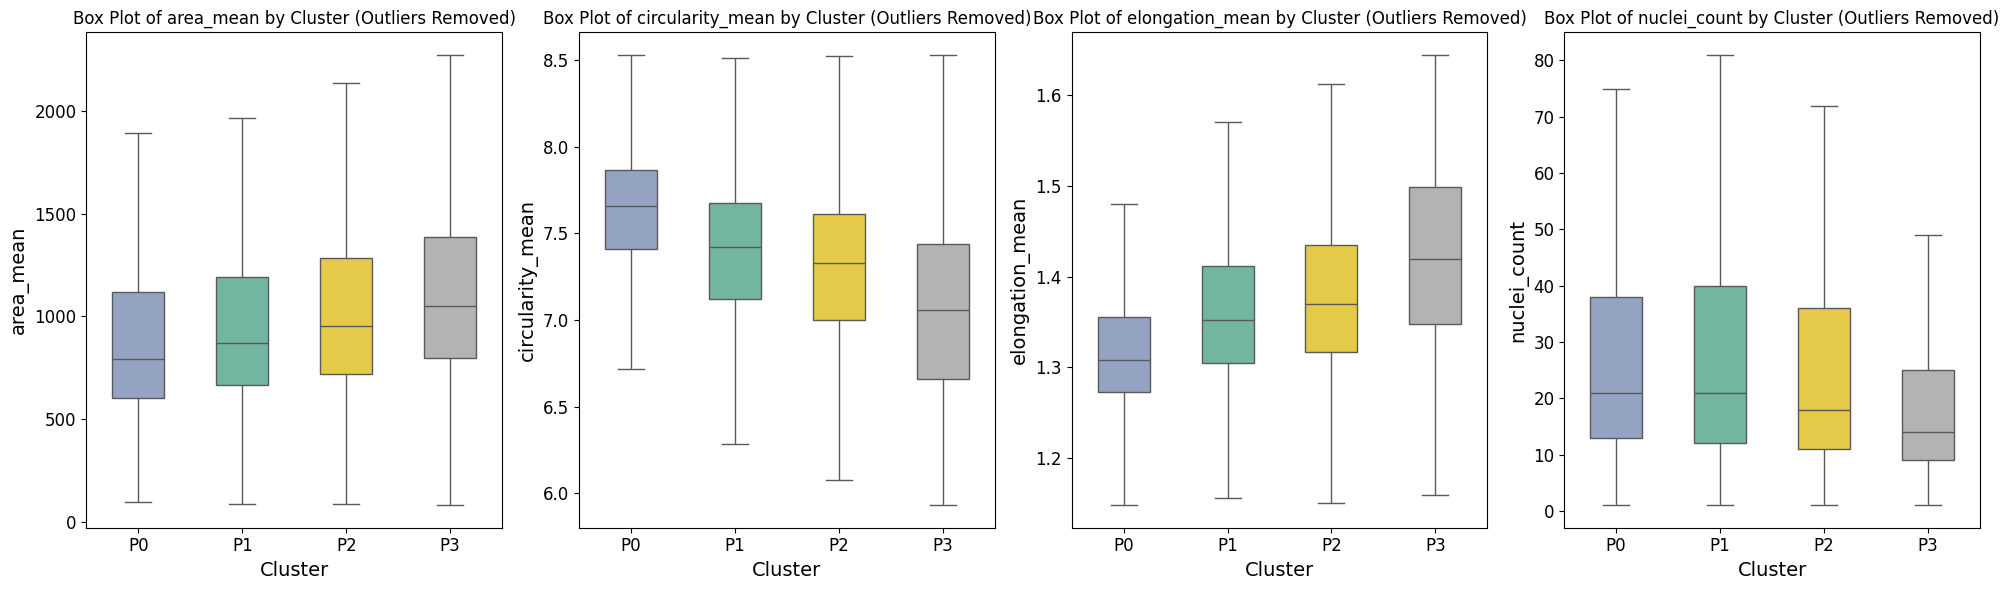

In [37]:
cluster_map = {0: 'P0', 1: 'P2', 2: 'P3', 3: "P1"}
agg_df["Cluster"] = agg_df["cluster_mode"].map(cluster_map)
cluster_order = ["P0", "P1", "P2", "P3"]
cluster_colors = {"P0": '#8da0cb', "P1": '#66c2a5', "P2": '#ffd92f', "P3": '#b3b3b3'}
features = ['area_mean', 'circularity_mean', 'elongation_mean', 'nuclei_count']

p_value_table = []
fig, axes = plt.subplots(1, 4, figsize=(20, 6))
axes = axes.ravel()
for i, feature in enumerate(features):
    Q1 = agg_df[feature].quantile(0.25)
    Q3 = agg_df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    agg_df_filtered = agg_df[(agg_df[feature] >= lower_bound) & (agg_df[feature] <= upper_bound)]
    if agg_df_filtered.empty:
        print(f"Warning: No data for feature {feature} after filtering.")
        continue

    p_values = {}
    clusters = agg_df_filtered['Cluster'].unique()
    for cluster1 in clusters:
        for cluster2 in clusters:
            if cluster1 < cluster2:  # To avoid repeating comparisons
                data1 = agg_df_filtered[agg_df_filtered['Cluster'] == cluster1][feature]
                data2 = agg_df_filtered[agg_df_filtered['Cluster'] == cluster2][feature]
                _, p_val = kruskal(data1, data2)
                p_values[(cluster1, cluster2)] = p_val
                p_value_table.append({
                    'Feature': feature,
                    'Cluster 1': cluster1,
                    'Cluster 2': cluster2,
                    'p-value': p_val
                })

    ax = axes[i]
    sns.boxplot(x='Cluster', y=feature, data=agg_df_filtered, palette=cluster_colors, order=cluster_order, showfliers=False, width=0.5, ax=ax, hue='Cluster', legend=False)
    ax.set_title(f'Box Plot of {feature} by Cluster (Outliers Removed)', fontsize=12)
    ax.set_xlabel('Cluster', fontsize=14)
    ax.set_ylabel(feature, fontsize=14)
    ax.tick_params(axis='both', labelsize=12)

plt.tight_layout()
# plt.savefig('path_to_save_boxplot.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [34]:
p_value_df = pd.DataFrame(p_value_table)
print(p_value_df)

             Feature Cluster 1 Cluster 2        p-value
0          area_mean        P1        P3  8.491264e-140
1          area_mean        P1        P2   1.593459e-29
2          area_mean        P0        P3  9.394022e-283
3          area_mean        P0        P1   2.666392e-37
4          area_mean        P0        P2  8.218007e-118
5          area_mean        P2        P3   1.869240e-44
6   circularity_mean        P1        P3   0.000000e+00
7   circularity_mean        P1        P2   7.631898e-45
8   circularity_mean        P0        P1   0.000000e+00
9   circularity_mean        P0        P3   0.000000e+00
10  circularity_mean        P0        P2   0.000000e+00
11  circularity_mean        P2        P3  1.330007e-213
12   elongation_mean        P1        P3   0.000000e+00
13   elongation_mean        P1        P2   5.356204e-42
14   elongation_mean        P0        P1   0.000000e+00
15   elongation_mean        P0        P3   0.000000e+00
16   elongation_mean        P0        P2   0.000